In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt

path = '/media/robert/Data_Storage/Data/Tests/Beam_Multimode/'
lam = 0.8
tau = 35.

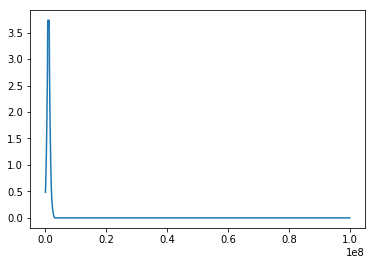

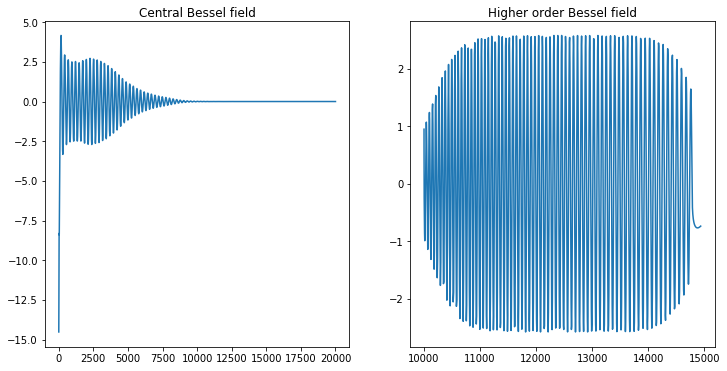

In [2]:
# Create the desired intensity profile
ion = {'atom' : ionization.Ar,
       'tau' : tau,
       'type' : 'gaussian'}
z0 = 0.75e6
zf = 100e6
dz = 0.5e6
sigmaIn = 15e4
sigmaOut = 15e4
N = 100000
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)
plt.plot(z, I)

params = {
    'Nr' : 5000,
    'R' : 20e3,
    'w' : 100,
    'lam' : 0.8
}
r, E = bessel.bessel_expansion(params, z, I)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(r, E.real)
plt.title('Central Bessel field')

sigmaIn = 1e4
sigmaOut = 1e4
dz = 0.75e6
z, I = profile.smoothed_gaussian_ramps(z0, dz, sigmaIn, sigmaOut, ion, N, zf)

params = {
    'lam' : lam,
    'rmax' : [params['R']],
    'rc' : [12.5e3],
    'r0' : [10e3],
    'w' : [2.5e3],
    'nGauss' : [8],
    'm' : [0.51]
}
E1, r1 = ray.super_gaussian_phase(params, I, z)
#E1 = E1*
plt.subplot(122)
plt.plot(r1, E1.real)
plt.title('Higher order Bessel field')
plt.show()

In [3]:
pulseParams = {
    'Nx' : 2**11,
    'Ny' : 2**11,
    'Nt' : 2**6,
    'X' : 30e3,
    'Y' : 30e3,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 4,
    'cyl' : True
}

plasmaParams = {
    'Nx' : pulseParams['Nx'],
    'Ny' : pulseParams['Ny'],
    'Nz' : 2**8,
    'X' : pulseParams['X'],
    'Y' : pulseParams['Y'],
    'Z' : 2.0e6, 
    'n0' : 0.1,
    'atom' : ionization.Ar,
    'path' : path,
    'load' : False,
    'cyl' : True
}
order = 4

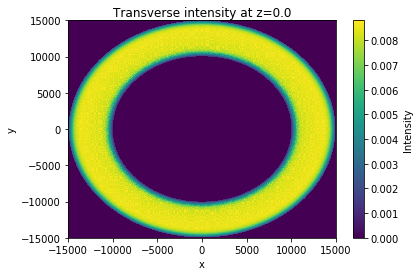

In [4]:
# Test the higher order Bessel beam
pulseParams['name'] = 'J0Beam'
beam0 = laserbeam.Laser(pulseParams)
e = beam0.reconstruct_from_cyl(r, E, beam0.x, beam0.y)
beam0.initialize_field(e)

pulseParams['name'] = 'J1Beam'
beam1 = laserbeam.Laser(pulseParams)
e = beam1.reconstruct_from_cyl(r1, E1, beam1.x, beam1.y)
phi = np.zeros(np.shape(e)) 
# Handle when x/y -> ininity
phi[int(beam1.Nx/2), int(beam1.Ny/2):] = np.pi/2
phi[int(beam1.Nx/2), :int(beam1.Ny/2)] = -np.pi/2
# Handle the positive x half plane
sel = np.array(beam1.x > 0)
xp = beam1.x[sel]
xp = np.reshape(xp, (np.size(xp), 1))
phi[int(beam1.Nx/2+1):, :] = np.arctan(beam1.y/xp)
# Handle the negative x half plane
sel = np.array(beam1.x < 0)
xn = beam1.x[sel]
xn = np.reshape(xn, (np.size(xn), 1))
phi[:int(beam1.Nx/2), :] = np.arctan(beam1.y/xn) + np.pi
e = e * np.exp(1j*phi*order)
beam1.initialize_field(e)
beam1.plot_current_intensity()

In [5]:
beam0.propagate(np.linspace(0, plasmaParams['Z'], plasmaParams['Nz']), 1.0)
beam1.propagate(np.linspace(0, plasmaParams['Z'], plasmaParams['Nz']), 1.0)

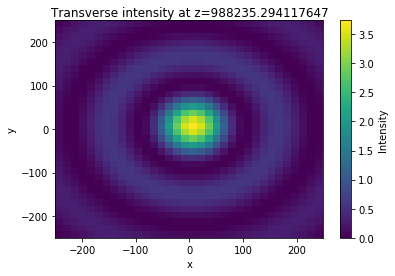

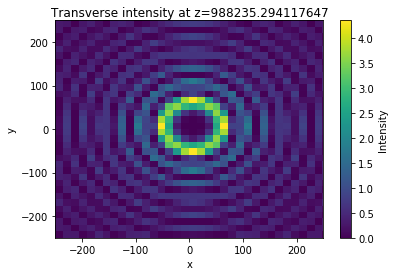

In [6]:
ind = 127
beam0.plot_intensity_at(ind, lim=[-250, 250])
beam1.plot_intensity_at(ind, lim=[-250, 250])

In [7]:
pulseParams['name'] = 'J0Pulse'
pulse0 = laserpulse.Pulse(pulseParams)
plasmaParams['name'] = 'J0Plasma'
argon0 = plasma.UniformPlasma(plasmaParams)

e = pulse0.reconstruct_from_cyl(r, E, pulse0.x, pulse0.y)
e = e[None, :, :] * np.exp(-pulse0.t[:, None, None]**2 * np.pi/(2*tau**2))
pulse0.initialize_field(e)

interactions.pulse_plasma(pulse0, argon0)

In [8]:
pulseParams['name'] = 'J1Pulse'
pulse1 = laserpulse.Pulse(pulseParams)
plasmaParams['sourcePath'] = path
plasmaParams['sourceName'] = plasmaParams['name']
plasmaParams['name'] = 'J1Plasma'
argon1 = plasma.ExistingPlasma(plasmaParams)

e = pulse1.reconstruct_from_cyl(r1, E1, pulse1.x, pulse1.y)
e = e[None, :, :] * np.exp(-pulse1.t[:, None, None]**2 * np.pi/(2*tau**2))
r = np.sqrt(pulse1.x[:, None]**2 + pulse1.y[None, :]**2)
phi = np.zeros(np.shape(r)) 
# Handle when x/y -> ininity
phi[int(pulse1.Nx/2), int(pulse1.Ny/2):] = np.pi/2
phi[int(pulse1.Nx/2), :int(pulse1.Ny/2)] = -np.pi/2
# Handle the positive x half plane
sel = np.array(pulse1.x > 0)
xp = pulse1.x[sel]
xp = np.reshape(xp, (np.size(xp), 1))
phi[int(pulse1.Nx/2+1):, :] = np.arctan(pulse1.y/xp)
# Handle the negative x half plane
sel = np.array(pulse1.x < 0)
xn = pulse1.x[sel]
xn = np.reshape(xn, (np.size(xn), 1))
phi[:int(pulse1.Nx/2), :] = np.arctan(pulse1.y/xn) + np.pi
e = e * np.exp(1j*phi*order)
pulse1.initialize_field(e)

interactions.pulse_plasma(pulse1, argon1)

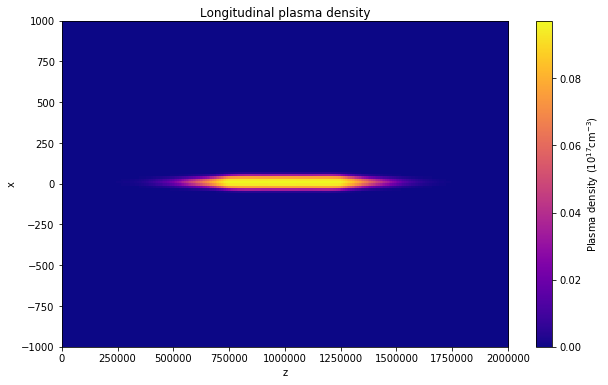

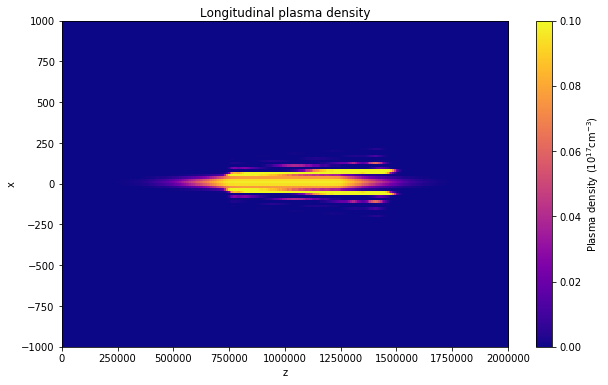

In [9]:
argon0.plot_long_density_center(lim=[-1000, 1000])
argon1.plot_long_density_center(lim=[-1000, 1000])